In [18]:
import os
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy

# Main model
main_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')
x = main_model.output
x = Dropout(0.5)(x)  
prediction = Dense(1, activation="sigmoid")(x)  

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Path to train and validation data
train_dir = "/cluster/home/sowada23/PneumoniaDetector/database/chest_xray/train"
val_dir = "/cluster/home/sowada23/PneumoniaDetector/database/chest_xray/val"

image_generator = ImageDataGenerator()

# Calculating the weights
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)
class_weight = {0: weight_for_0, 1: weight_for_1}

# Early stopping to deal with overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

# Data generator for training images with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training dataset, applying the transformations
train = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

# Data generator for validation images without data augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

# history of the model
history = model.fit(
    train,
    epochs=50,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
    callbacks=[reduce_lr, early_stopping]
)

Found 5216 images belonging to 2 classes.
Found 476 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 57s 268ms/step - loss: 0.0103 - accuracy: 0.9906 - val_loss: 0.2333 - val_accuracy: 0.9538 - lr: 1.0000e-04
Epoch 2/50
 48/100 [=============>................] - ETA: 13s - loss: 0.0055 - accuracy: 0.9928

KeyboardInterrupt: 

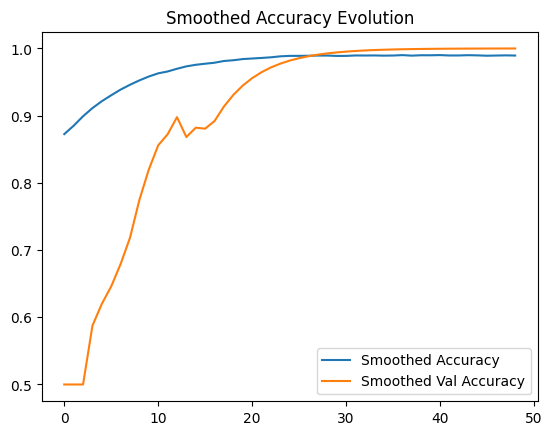

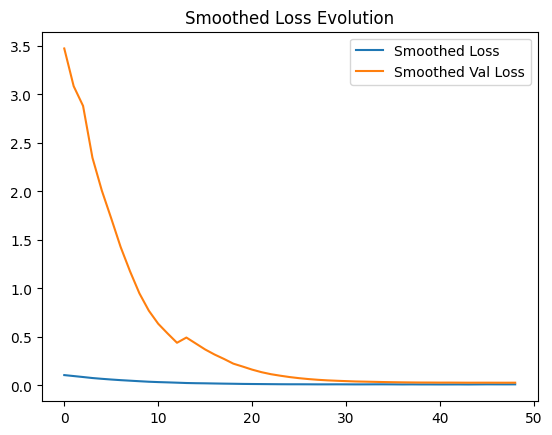

In [4]:
# Plot accuracy and loss
def smooth_curve(points, factor=0.8):
    smooth_points = []
    for point in points:
        if smooth_points:
            smooth_points.append(smooth_points[-1] * factor + point * (1 - factor))
        else:
            smooth_points.append(point)
    return smooth_points

# Plotting the smooth accuracy curves
plt.plot(smooth_curve(history.history['accuracy']), label='Smoothed Accuracy')
plt.plot(smooth_curve(history.history['val_accuracy']), label='Smoothed Val Accuracy')
plt.title('Smoothed Accuracy Evolution')
plt.legend()
plt.show()

# Plotting the smooth loss curves
plt.plot(smooth_curve(history.history['loss']), label='Smoothed Loss')
plt.plot(smooth_curve(history.history['val_loss']), label='Smoothed Val Loss')
plt.title('Smoothed Loss Evolution')
plt.legend()
plt.show()

In [7]:
# Save the model
model.save('models/pneumonia_detector.h5')

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np 

# Load the trained model
model = load_model('/cluster/home/sowada23/PneumoniaDetector/models/pneumonia_detector.h5') 

# Ppreprocess hte input image
def pre_image(img_path):
    img = image.load_img(img_path, target_size=(180, 180))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# Use the model to predict the likelihood of Pneumonia
def predict_image(img_path, model):
    img_array = pre_image(img_path)
    prediction = model.predict(img_array)
    likelihood = prediction[0][0]
    if likelihood > 0.5:
        print(f"Likelihood of Pneumonia: {likelihood:.2f}")
    else:
        print(f"Likelihood of Normal: {1 - likelihood:.2f}")

# Path to the input image
img_path = '/cluster/home/sowada23/PneumoniaDetector/InputImage/NORMAL/PHOTO-2024-11-09-22-24-04.jpg'
predict_image(img_path, model)

1/1 [==============================] - 1s 1s/step
Likelihood of Pneumonia: 0.99
